# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

Deep Learning for Coders with fastai & PyTorch de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the LICENSE file for details.

In [2]:
from fastai2.vision.all import *

In [3]:
# Utilitaire
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

# Classification d'images

## Distinction fine de 40 races de chiens et de chats

[The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
*Omkar M Parkhi and Andrea Vedaldi and Andrew Zisserman and C. V. Jawahar*

Exploration du jeu de données :

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#2) [Path('/storage/data/oxford-iiit-pet/images'),Path('/storage/data/oxford-iiit-pet/annotations')]

In [14]:
images_list = (path/"images").ls()
images_list

(#7393) [Path('/storage/data/oxford-iiit-pet/images/american_bulldog_146.jpg'),Path('/storage/data/oxford-iiit-pet/images/japanese_chin_12.jpg'),Path('/storage/data/oxford-iiit-pet/images/Sphynx_247.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_158.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_76.jpg'),Path('/storage/data/oxford-iiit-pet/images/shiba_inu_207.jpg'),Path('/storage/data/oxford-iiit-pet/images/Siamese_56.jpg'),Path('/storage/data/oxford-iiit-pet/images/keeshond_194.jpg'),Path('/storage/data/oxford-iiit-pet/images/miniature_pinscher_89.jpg'),Path('/storage/data/oxford-iiit-pet/images/leonberger_42.jpg')...]

In [15]:
filepath = images_list[1]
filepath.name

'japanese_chin_12.jpg'

In [20]:
def get_label_from_filename(filename):
    return re.findall(r'(.+)_\d+.jpg$', filename)

get_label_from_filename(filepath.name)

['japanese_chin']

In [26]:
img0 = Image.open(images_list[0])
img1 = Image.open(images_list[1])
img2 = Image.open(images_list[2])

print(img0.size, img1.size, img2.size)

print(get_label_from_filename(images_list[0].name),
      get_label_from_filename(images_list[1].name),
      get_label_from_filename(images_list[2].name))

(375, 500) (332, 500) (250, 201)
['american_bulldog'] ['japanese_chin'] ['Sphynx']


In [ ]:
show_image(img0)
show_image(img1)
show_image(img2)

Préparation des données à l'aide de l'API fastai2 **DataBlock** :

In [29]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

Quelles transformations sont appliquées pour augmenter la variété des données d'entrainement ?

In [27]:
[tranform.name for tranform in aug_transforms(size=224, min_scale=0.75)]

['AffineCoordTfm', 'LightingTfm', 'RandomResizedCropGPU']

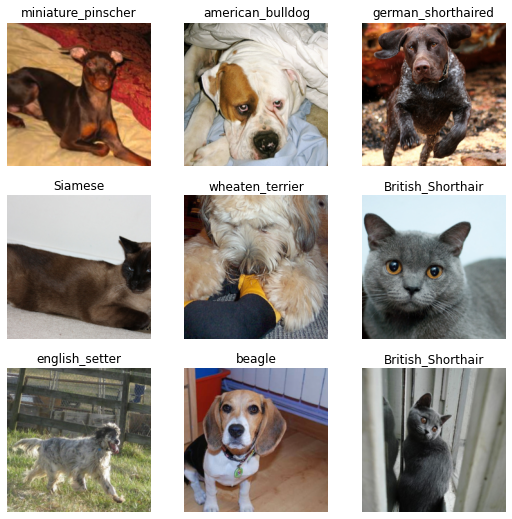

In [30]:
dls.show_batch()

## Augmentation de la variété des images d'entrainement - Stratégie de "presizing"

Nous avons besoin que nos images aient les mêmes dimensions, afin qu'elles puissent être assemblées en tenseurs pour être transmises au GPU. Nous voulons également minimiser le nombre de calculs d'augmentation distincts que nous effectuons. 

Pour optimiser les performances, nous devrions donc, dans la mesure du possible, fusionner nos transformations d'augmentation en un minimum de transformations (pour réduire le nombre de calculs et le nombre d'opérations avec perte) et transformer les images en tailles uniformes (pour exécuter efficacement les calculs sur le GPU).

Le défi est que, si les transformations d'augmentation sont réalisées après avoir redimensionné l'image, elles pourraient introduire des zones vides parasites, dégrader les données, ou les deux. Par exemple, la rotation d'une image de 45 degrés remplit les coins de vide, ce qui n'apprendra rien au modèle. De nombreuses opérations de rotation et de zoom nécessiteront une interpolation pour créer des pixels. Ces pixels interpolés sont dérivés des données de l'image originale mais sont toujours de moindre qualité.

Pour contourner ces défis, le **presizing** adopte deux stratégies :

1. Premièrement, redimensionner les images à des "dimensions relativement grandes", c'est-à-dire à des dimensions nettement supérieures à celles de la taille cible en entrée du modèle. 

2. Deuxièmement, fusionner toutes les opérations d'augmentation (y compris un redimensionnement à la taille cible finale) en une seule, et exécuter l'opération combinée sur le GPU une seule fois à la fin du traitement, plutôt que de les exécuter individuellement et d'interpoler plusieurs fois.

La première étape, le redimensionnement, crée des images suffisamment grandes pour qu'elles aient une marge de manœuvre qui permette d'autres transformations d'augmentation sur leurs régions intérieures sans créer de zones vides. Cette transformation fonctionne par redimensionnement en carré, en utilisant une grande taille de recadrage. Sur le jeu de données d'entraînement, la zone de recadrage est choisie au hasard, et la taille du recadrage est choisie pour couvrir toute la largeur ou la hauteur de l'image (la plus petite des deux).

Dans la deuxième étape, le GPU est utilisé pour toute les augmentations de données, et toutes les opérations potentiellement destructrices sont effectuées ensemble, avec une seule interpolation à la fin.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="presizing.png">

Cette image montre les deux étapes :

1. *Réduire la largeur ou la hauteur totale* : exécuté dans `item_tfms`, donc c'est appliqué à chaque image individuelle avant qu'elle ne soit copiée sur le GPU. Utilisé pour s'assurer que toutes les images ont la même taille. Sur le jeu d'entrainement, la zone de recadrage est choisie au hasard. Sur le jeu de validation, le carré central de l'image est toujours choisi.

2. *Recadrage et augmentation aléatoires* : exécuté dans `batch_tfms`, donc c'est appliqué à un mini-batch en une seule fois sur le GPU, ce qui signifie que c'est rapide. Sur le jeu de validation, seul le redimensionnement à la taille finale nécessaire pour le modèle est réalisé. Sur le jeu d'entrainement, le recadrage aléatoire et toute autre augmentation sont effectuées en premier.

Pour mettre en œuvre ce processus dans fastai2, vous utilisez `Resize` comme transformation d'item avec une grande taille, et `RandomResizedCrop` comme une transformation de batch avec une plus petite taille. `RandomResizedCrop` sera ajouté automatiquement pour vous si vous incluez le paramètre `min_scale` dans votre fonction `aug_transforms`, comme vous le voyez dans l'appel `DataBlock` ci-dessus. Alternativement, vous pouvez utiliser `pad` ou `squish` au lieu de `crop` (par défaut) pour le `Resize` initial.

Vous pouvez voir dans cet exemple la différence entre une image qui a été zoomée, interpolée, tournée, puis interpolée à nouveau sur la droite (ce qui est l'approche utilisée par toutes les autres bibliothèques de deep learning), par rapport à une image qui a été zoomée et tournée en une seule opération, puis interpolée une seule fois sur la gauche (l'approche fastai2) :

In [36]:
# Création de batchs à partir d'un dataset de 100 images identiques
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([images_list[0]]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()

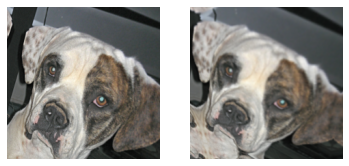

In [37]:
# Transformations réalisées les unes après les autres
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# Transformations réalisées dans un pipeline sur le GPU
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), 
                       Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)

# Comparaison des résultats
_,axs = subplots(1, 2)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

## Tester et mettre au point un DataBlock

In [39]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))

pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x374
  Pipeline: partial -> Categorize
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying partial gives
      shiba_inu
    applying Categorize gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=500x374, TensorCategory(33))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=500x374, TensorCategory(33))
    applying ToTensor gives
      (TensorImage of size 3x374x500, TensorC

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 374 and 375 in dimension 2 at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensor.cpp:612

## Entrainer un premier modèle

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

fastai2 a choisi une fonction de coût (loss function) automatiquement pour cette tâche de classification (détectée grace à la donnée y de type CategoryBlock en sortie) :

In [41]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Mesure de l'erreur de classification - Cross entropy loss

### Visualiser les activations en sortie du modèl et les labels attendus

In [42]:
x,y = dls.one_batch()

Visualiser les labels attendus - Category encoding :

In [43]:
y

TensorCategory([22, 27, 27, 14, 22, 30,  2,  1,  6,  0, 24, 14, 36,  4, 32, 14,  5, 34,
        26, 36, 29, 32, 24,  5,  6, 16, 24, 14, 32, 17,  2,  5, 32, 33, 35,  5,
        11, 26,  5, 21, 36, 15,  1,  6, 24, 30, 31, 25,  4,  3, 20, 19, 26,  3,
        24, 29, 20, 34, 32, 19, 28,  0, 16, 32], device='cuda:0')

In [44]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

In [49]:
y[0].item(), dls.vocab[y[0]]

(22, 'havanese')

In [51]:
labels = [dls.vocab[cat_index] for cat_index in y]
labels[:10]

['havanese',
 'newfoundland',
 'newfoundland',
 'basset_hound',
 'havanese',
 'saint_bernard',
 'Birman',
 'Bengal',
 'Maine_Coon',
 'Abyssinian']

Visualiser les activations en sortie du modèle - One hot encoding :

In [54]:
print(x.shape, y.shape)

preds,_ = learn.get_preds(dl=[(x,y)])

print(preds.shape)
preds[0]

torch.Size([64, 3, 224, 224]) torch.Size([64])


torch.Size([64, 37])


tensor([0.0058, 0.0351, 0.0151, 0.0125, 0.0087, 0.0004, 0.0095, 0.0084, 0.0358,
        0.0051, 0.0164, 0.0083, 0.0074, 0.0045, 0.0061, 0.0033, 0.0104, 0.0832,
        0.0042, 0.0194, 0.0137, 0.0965, 0.2261, 0.0320, 0.0433, 0.0315, 0.0032,
        0.0241, 0.0063, 0.0205, 0.0196, 0.0155, 0.0054, 0.0087, 0.0035, 0.0120,
        0.1384])

In [55]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Equivalent de sigmoid pour plus de 2 catégories : Softmax

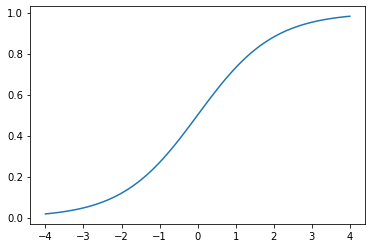

In [33]:
plot_function(torch.sigmoid, min=-4,max=4)

In [34]:
#hide
torch.random.manual_seed(42);

In [35]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [36]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [37]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [38]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Mesure de distance aux labels pour plus de 2 catégories : Negative Log Likelihood

In [39]:
targ = tensor([0,1,0,1,1,0])

In [40]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [41]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [42]:
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
df

,3,7,targ,idx,loss
0,0.602469,0.397531,0,0,0.602469
1,0.502065,0.497935,1,1,0.497935
2,0.133188,0.866811,0,2,0.133188
3,0.996640,0.003360,1,3,0.003360
4,0.595949,0.404051,1,4,0.404051
5,0.366118,0.633882,0,5,0.366118


In [43]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [44]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Appliquer la fonction `log`

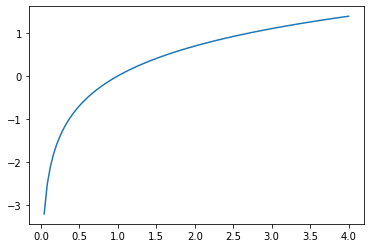

In [45]:
plot_function(torch.log, min=0,max=4)

In [46]:
loss_func = nn.CrossEntropyLoss()

In [47]:
loss_func(acts, targ)

tensor(1.8045)

In [48]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [49]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

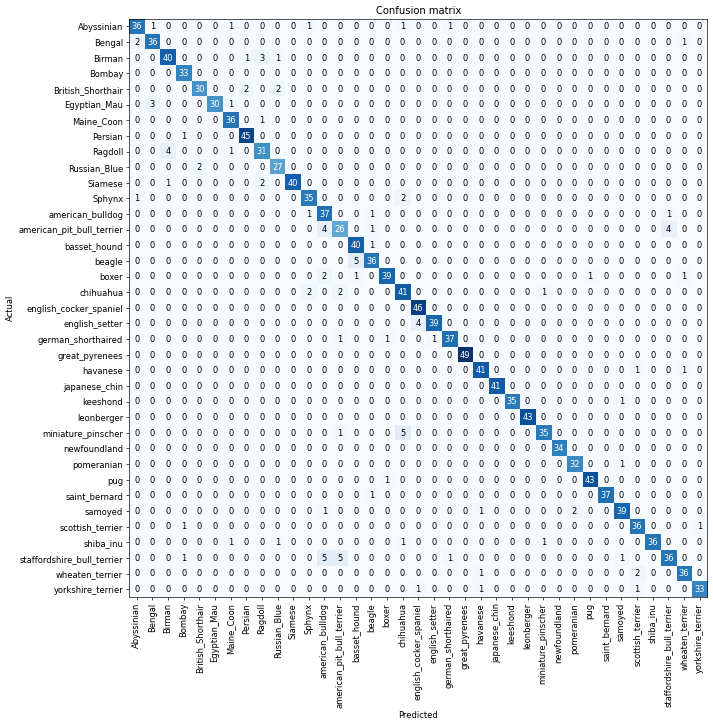

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [51]:
interp.most_confused(min_val=5)

[('beagle', 'basset_hound', 5),
 ('miniature_pinscher', 'chihuahua', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

## Improving our model

### Learning rate finder

In [54]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.691894,5.252175,0.490528,00:25


epoch,train_loss,valid_loss,error_rate,time
0,4.221415,4.066999,0.776725,00:32
1,2.341416,1.367978,0.422192,00:31


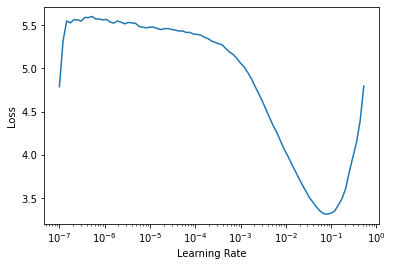

In [53]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [55]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 6.31e-03


In [56]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=6e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.063206,0.387836,0.110961,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.729967,0.646346,0.173207,00:31
1,0.406494,0.284538,0.088633,00:31


### Unfreezing and transfer learning

In [57]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.138528,0.339928,0.104195,00:25
1,0.517963,0.286641,0.087957,00:25
2,0.315610,0.246128,0.073748,00:25


In [58]:
learn.unfreeze()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=7.585775847473997e-07)

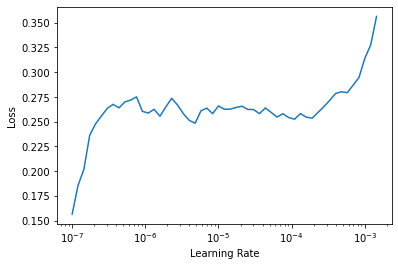

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.258214,0.229297,0.071719,00:32
1,0.244831,0.225388,0.074425,00:32
2,0.225734,0.218312,0.067659,00:31
3,0.210456,0.214465,0.062923,00:32
4,0.194173,0.211718,0.062246,00:31
5,0.182622,0.213349,0.065629,00:31


### Discriminative learning rates

In [61]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.115057,0.337810,0.105548,00:26
1,0.539760,0.291335,0.092016,00:26
2,0.332870,0.237753,0.077131,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.267482,0.234121,0.073072,00:31
1,0.254349,0.229980,0.072395,00:31
2,0.229564,0.231214,0.073748,00:31
3,0.203906,0.224533,0.074425,00:31
4,0.189361,0.218713,0.069012,00:31
5,0.180013,0.213483,0.065629,00:31
6,0.159577,0.213275,0.064276,00:31
7,0.149588,0.208382,0.062923,00:31
8,0.140246,0.211009,0.065629,00:31
9,0.130604,0.209260,0.062246,00:31


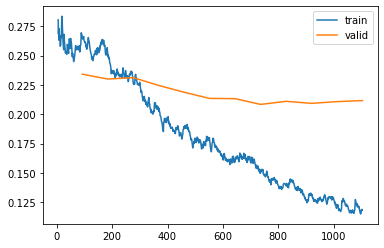

In [62]:
learn.recorder.plot_loss()

### Selecting the number of epochs

### Deeper architectures

In [63]:
#from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate) #.to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.273174,0.285852,0.089986,00:45
1,0.565775,0.264977,0.080514,00:43
2,0.432513,0.252678,0.081191,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.286545,0.242117,0.081867,01:05
1,0.303293,0.379559,0.108931,00:57
2,0.253836,0.267058,0.079161,00:57
3,0.158468,0.224737,0.063599,00:57
4,0.094714,0.225613,0.062246,00:57
5,0.054199,0.215326,0.059540,00:57


# Autres problèmes de vision par ordinateur

## Multi-label classification

### The data

In [2]:
path = untar_data(URLs.PASCAL_2007)

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [ ]:
df.iloc[:,0]
df.iloc[0,:]
# Trailing ‘:’s are always optional (in numpy, PyTorch, pandas, etc),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [ ]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [4]:
df1 = pd.DataFrame()
df1['a'] = [1,2,3,4]
df1

,a
0,1
1,2
2,3
3,4


In [5]:
df1['b'] = [10, 20, 30, 40]
df1['a'] + df1['b']

0    11
1    22
2    33
3    44
dtype: int64

### End sidebar

### Constructing a data block

In [ ]:
dblock = DataBlock()

In [ ]:
dsets = dblock.datasets(df)

In [ ]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/pascal_2007/train/008663.jpg'),
 ['car', 'person'])

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

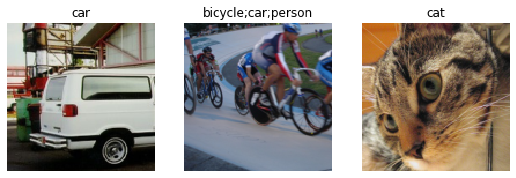

In [ ]:
dls.show_batch(nrows=1, ncols=3)

### Binary cross entropy

In [ ]:
learn = cnn_learner(dls, resnet18)

In [ ]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [ ]:
activs[0]

tensor([ 2.0258, -1.3543,  1.4640,  1.7754, -1.2820, -5.8053,  3.6130,  0.7193, -4.3683, -2.5001, -2.8373, -1.8037,  2.0122,  0.6189,  1.9729,  0.8999, -2.6769, -0.3829,  1.2212,  1.6073],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0082, device='cuda:5', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [ ]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [ ]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.903610,0.659728,0.263068,00:07
1,0.724266,0.346332,0.525458,00:07
2,0.415597,0.125662,0.937590,00:07
3,0.254987,0.116880,0.945418,00:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.123872,0.132634,0.940179,00:08
1,0.112387,0.113758,0.949343,00:08
2,0.092151,0.104368,0.951195,00:08


In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10436797887086868,0.93057781457901]

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10436797887086868,0.9416930675506592]

In [ ]:
preds,targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9554)

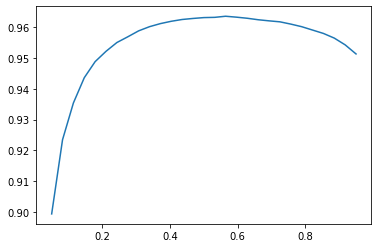

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

### Assemble the data

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#50) [Path('13.obj'),Path('07.obj'),Path('06.obj'),Path('13'),Path('10'),Path('02'),Path('11'),Path('01'),Path('20.obj'),Path('17')...]

In [ ]:
(path/'01').ls()

(#1000) [Path('01/frame_00281_pose.txt'),Path('01/frame_00078_pose.txt'),Path('01/frame_00349_rgb.jpg'),Path('01/frame_00304_pose.txt'),Path('01/frame_00207_pose.txt'),Path('01/frame_00116_rgb.jpg'),Path('01/frame_00084_rgb.jpg'),Path('01/frame_00070_rgb.jpg'),Path('01/frame_00125_pose.txt'),Path('01/frame_00324_rgb.jpg')...]

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('13/frame_00349_pose.txt')

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

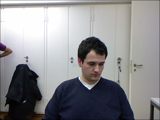

In [ ]:
im.to_thumb(160)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
get_ctr(img_files[0])

tensor([384.6370, 259.4787])

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

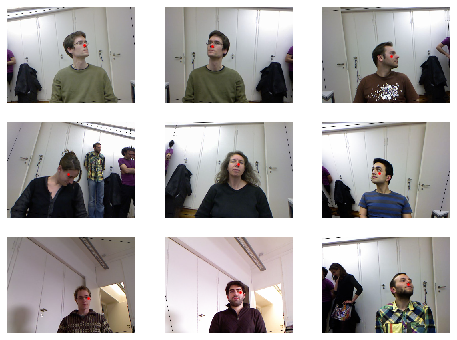

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
yb[0]

tensor([[0.0111, 0.1810]], device='cuda:5')

### Training a model

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

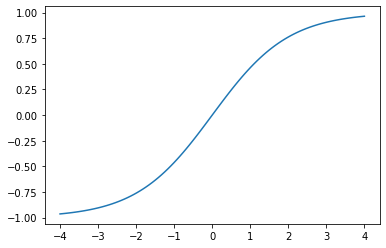

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

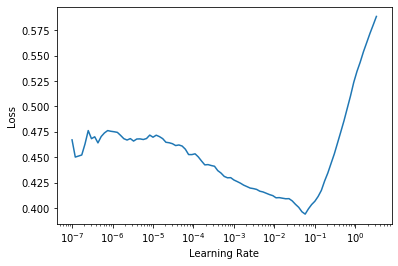

In [ ]:
learn.lr_find()

In [ ]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.045840,0.012957,00:36
1,0.006369,0.001853,00:36
2,0.003000,0.000496,00:37
3,0.001963,0.000360,00:37
4,0.001584,0.000116,00:36


In [ ]:
math.sqrt(0.0001)

0.01

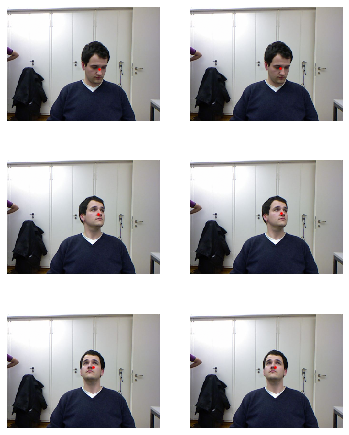

In [ ]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))